In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# save fruit-dataset into csv file
df = pd.read_csv('Fruit-Dataset.txt', delimiter="\t")

In [3]:
df.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [4]:
# we will not use fruit_subtype feature
df = df.drop(['fruit_subtype'], axis=1)

In [5]:
# get label_name dictionary
df1 = df[['fruit_name', 'fruit_label']].drop_duplicates().reset_index(drop=True)
label_names = dict(zip(list(df1['fruit_label']), list(df1['fruit_name'])))
label_names

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

## Appy the unsupervised process to set the label of data “Fruit Dataset.txt” as much as possible the label already have in the dataset. 

- Visualize the labelled data

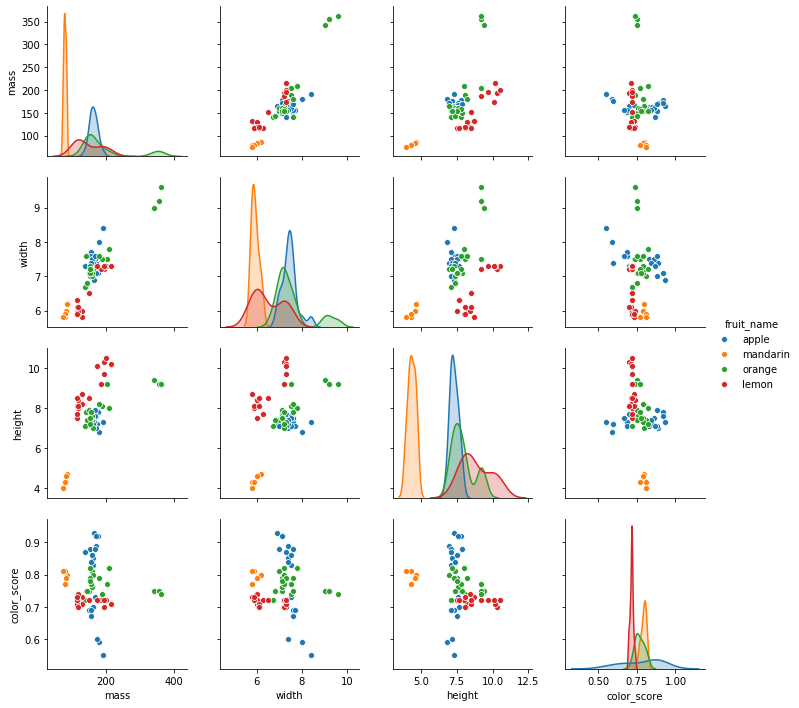

In [6]:
sns.pairplot(df.drop(['fruit_label'], axis=1), hue='fruit_name')
plt.show()

In [7]:
# save array of features X and labels y
X = df[['mass', 'width', 'height', 'color_score']].values
y = df[['fruit_label']].values

In [8]:
# scale data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [9]:
# dataframe for scaled data
df_scaled = pd.concat((pd.DataFrame(X_scaled, columns=['mass', 'width', 'height', 'color_score']), df[['fruit_name']]), axis=1)
df_scaled.head()

,mass,width,height,color_score,fruit_name
0,0.529442,1.598690,-0.291397,-2.793595,apple
1,0.309462,1.104854,-0.661922,-2.268684,apple
2,0.236136,0.364100,-0.365502,-2.137456,apple
3,-1.413709,-1.117409,-2.218131,0.487100,mandarin
4,-1.450372,-1.364327,-2.292236,0.355872,mandarin


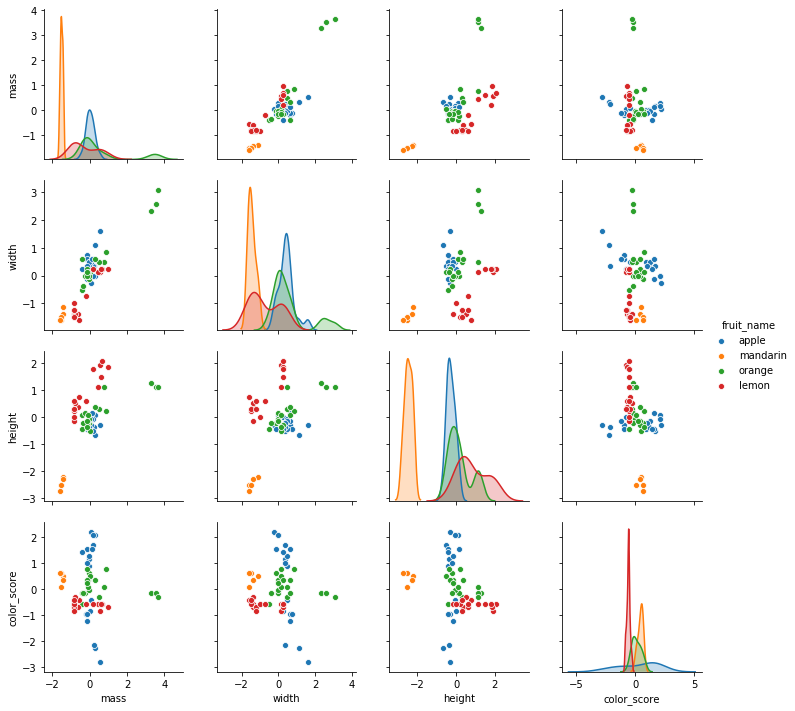

In [10]:
# draw a pairplot again but with scaled data
sns.pairplot(df_scaled, hue='fruit_name')
plt.show()

### K-mean

- Using elbow method to determine the number of cluster

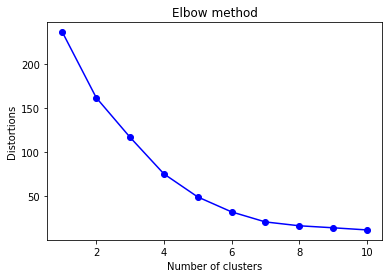

In [11]:
distortions = []

for i in range(1, 11):
    model = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=10e-04, random_state=0)
    model.fit(X_scaled)
    distortions.append(model.inertia_)

plt.plot(range(1, 11), distortions, marker='o', color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.title('Elbow method')
plt.show()
    

- Based on the graph, the number of clusters should be 4.

In [12]:
# build a Kmean model with n_cluster = 4
km_model = KMeans(n_clusters=4, init='random', n_init=10, max_iter=300, tol=10e-04, random_state=0)
y_pred = km_model.fit_predict(X_scaled)

# the predicted labels
y_pred

array([1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
# the true labels
y = y.reshape(-1,)
y

array([1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

- Using adjusted rand score to evalute a model.
- Computing the adjusted rand score is one of the most popular way to evaluate the performance of a clustering algorithm (for labelled data). Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the adjusted Rand index is a function that measures the similarity of the two assignements, ignoring permutations and with chance normalization.
- The adjusted rand score is between -1 and 1

In [14]:
print("Adjusted rand score:")
print(metrics.adjusted_rand_score(y, y_pred))

Adjusted rand score:
0.2173295454545455


### Meanshift

In [15]:
# The following bandwidth can be automatically detected using estimate_bandwidth function
bandwidth = estimate_bandwidth(X_scaled)
bandwidth

1.8373901315090466

In [16]:
# build a meanshift model
ms_model = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True)
y_pred = ms_model.fit_predict(X_scaled)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [17]:
print("Adjusted rand score:")
print(metrics.adjusted_rand_score(y, y_pred))

Adjusted rand score:
0.1309148264984227


### DBScan

In [18]:
# build DBscan model with two hyperparameter; return eps, min_samples, the adjusted rank score and the number of clusters 
def adjusted_rand_score(eps, min_samples):
    db_model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', metric_params=None, algorithm='auto', n_jobs=None)
    y_pred = db_model.fit_predict(X_scaled)
    return eps, min_samples, metrics.adjusted_rand_score(y, y_pred), len(set(y_pred))

In [19]:
# test to find the best hyperparameters (based on adjusted rank score and the number of clusters)
eps_list = np.linspace(0.1, 1, 10)
min_samples_list = np.linspace(1, 10, 10)
test_models = []

for eps in eps_list:
    for min_samples in min_samples_list:
        test_models.append(adjusted_rand_score(eps, min_samples))

# sort test_models based on the adjusted rand scores
test_models.sort(key=lambda x: x[2])

# filter the test models with good adjusted rand score (> 0.3) 
test_models = [x for x in test_models if x[2] > 0.3]
test_models

[(0.6, 2.0, 0.30043859649122806, 8),
 (0.6, 3.0, 0.30043859649122806, 8),
 (0.6, 4.0, 0.30203990884331056, 6),
 (0.6, 1.0, 0.30454412195836994, 14),
 (0.6, 5.0, 0.3345154897256702, 5),
 (0.8, 6.0, 0.3556787233025945, 4),
 (0.7000000000000001, 5.0, 0.3588584061903326, 5),
 (0.9, 6.0, 0.36791870459186093, 4),
 (0.9, 7.0, 0.36791870459186093, 4),
 (0.7000000000000001, 4.0, 0.3870428627605191, 5),
 (0.7000000000000001, 2.0, 0.39067255768286696, 6),
 (0.7000000000000001, 3.0, 0.39067255768286696, 6),
 (0.7000000000000001, 1.0, 0.39484510532837674, 11),
 (0.8, 5.0, 0.41344521511374105, 5),
 (0.8, 4.0, 0.41767068273092367, 5)]

- With eps = 0.9 and min_samples = 7, the prediction has highest adjusted rand score and the number of clusters is correct (4)

In [20]:
# build a DBSCan model with eps = 0.9 and min_samples = 7 again
best_db_model = DBSCAN(eps=0.9, min_samples=7, metric='euclidean', metric_params=None, algorithm='auto', n_jobs=None)
y_pred = best_db_model.fit_predict(X_scaled)
y_pred

array([-1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  1,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2], dtype=int64)

In [21]:
print("Adjusted rand score:")
print(metrics.adjusted_rand_score(y, y_pred))

Adjusted rand score:
0.36791870459186093


**Conclusion**
- Based on the adjusted rand score, the DBScan model (eps = 0.9 and min_samples = 7) is the best model to cluster our data.

## After clustering, apply one machine learning you know to build a model for classification depending on your labels.

- Using **KNN** model.
- Don' t split data into training set and testing set because our data is small (just 60 samples) 

Using GridSearchCV to find the best hyperparameter (k- the number of neighbors)

In [22]:
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 10)}
param_grid

{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [23]:
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=6)

#fit model to data
knn_gscv.fit(X_scaled, y)

GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [24]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

In [25]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.9830508474576272

After using GridSearchCV, we choose the n_neighbors = 4

In [26]:
# build a new knn model with all data  we have
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_scaled, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

- So, we have a knn model and we can predict labels of new samples based on this model.  
- For example, a new sample with: mass = 200, width = 8, height = 7, color_score = 0.6. Which label does this sample have?

In [27]:
test_X = np.array([[200, 8, 7, 0.6]])

# scale data
test_X_scaled = scaler.transform(test_X)

# predict
label = knn.predict(test_X_scaled)
label_name = label_names[label[0]]
print("Label of a new sample: " + label_name)

Label of a new sample: apple
